In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import analysis_dir, annot_path
from storage import get_storage_functions
from hier_group import unpack_hier_names, annot_names, hier_lookup
import crossing_point

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'

#============================================================================
# config
#============================================================================
input_analysis_name = 'fix0_self_consistency'
conds = 'return_fixation,same_image'
clearance_thres = 100

#============================================================================
# paths
#============================================================================
rsc_dir = analysis_dir + 'fix0_self_consistency'
output_dir = rsc_dir + '-t2hh'

In [3]:
# Parameters
sess_name = "Pa210201"
rsc_dir = "../test_results/hier_group"
output_dir = "../test_results/hier_group"


# Check prereqs and params

In [4]:
rsc_path = Path(rsc_dir) / (sess_name + '.h5')
print('Loading return-fixation self-consistency results from', rsc_path)
rsc_path = rsc_path.expanduser()
assert rsc_path.is_file()

print('Using recording location annotations at', annot_path)
annot_path = Path(annot_path).expanduser()
assert annot_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading return-fixation self-consistency results from ../test_results/hier_group/Pa210201.h5
Using recording location annotations at ../db/bank_array_regions.csv
Saving results to ../test_results/hier_group/Pa210201.h5


In [5]:
with h5.File(rsc_path, 'r') as f:
    sdf_suffix = f[input_analysis_name+'/config/sdf_suffix'][()].decode()
    t_step = f[input_analysis_name+'/config/time_windows/t_step'][()]
sdf_suffix, t_step

('-mwa_50-hg', 10)

In [6]:
analysis_name = 'time_to_half_height'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'
save_results(group+'input_analysis_name', input_analysis_name)
save_results(group+'conds', conds)
save_results(group+'clearance_thres', clearance_thres, attrs=dict(unit='ms'))

In [9]:
conds = conds.split(',')
print('conditions to be processed in parallel:', conds)

conds_ = []
with h5.File(rsc_path, 'r') as f:
    for cond in conds:
        obj = f[input_analysis_name + '/' + cond]
        print(cond, obj)
        if isinstance(obj, h5.Dataset) and not (obj.size):
            continue
        conds_.append(cond)
conds = conds_
print('available conditions:', conds)
assert len(conds), 'no conditions to process'

conditions to be processed in parallel: ['return_fixation', 'same_image']
return_fixation <HDF5 group "/fix0_self_consistency/return_fixation" (7 members)>
same_image <HDF5 group "/fix0_self_consistency/same_image" (7 members)>
available conditions: ['return_fixation', 'same_image']


# Tally units and levels

In [10]:
cond_dsets = {
    cond: xr.load_dataset(rsc_path, group=input_analysis_name+'/'+cond, engine='h5netcdf')
    for cond in conds}

In [11]:
ds = next(iter(cond_dsets.values()))
names = ds['unit'].values
ts = ds['time'].values
for ds in cond_dsets.values():
    assert np.array_equal(names, ds['unit'].values)
    assert np.array_equal(ts, ds['time'].values)

hier_names = unpack_hier_names(names)

with h5.File(rsc_path, 'r') as f:
    dset = f[input_analysis_name+'/unit_names']
    all_groups_name = dset.attrs['all_groups_name'].astype(str)
    all_groups_uid = dset.attrs['all_groups_uid']

m_unit = hier_names[:,0] == 'Unit'
n_unit = m_unit.sum()
all_groups_idx = all_groups_uid + n_unit
all_hier_names = np.concatenate([hier_names[m_unit], unpack_hier_names(all_groups_name)])

In [12]:
adf = pd.read_csv(annot_path).set_index('Session').loc[[sess_name]].set_index('Bank')

unit_df = annot_names(
    np.concatenate([names[(hier_names[:,0] == 'Unit')], all_groups_name]),
    adf)

m = unit_df['Level'] == 'Unit'
unit_df['Index'] = -1
unit_df.loc[m,'Index'] = unit_df.index[m].astype(int)
unit_df.loc[~m,'Index'] = all_groups_idx

assert unit_df['Index'].min() == 0 and unit_df['Index'].max() == len(names)-1
unit_df['Name'] = all_hier_names[:,1]
unit_df

,Unit,Channel,Bank,Array ID,Level,Index,Name
0,Unit/1,1,0,1,Unit,0,1
1,Unit/2,2,0,1,Unit,1,2
2,Unit/3,3,0,1,Unit,2,3
3,Unit/4,4,0,1,Unit,3,4
4,Unit/4a,4,0,1,Unit,4,4a
...,...,...,...,...,...,...,...
103,Channel/55,55,1,2,Channel,103,55
104,Bank/0,-1,0,1,Bank,104,0
105,Bank/1,-1,1,2,Bank,105,1
106,Array/1,-1,-1,-1,Array,104,1


# Main

In [13]:
hiers = ['Unit', 'Channel', 'Bank', 'Array']
bycond_lat_df = {}

for cond, ds in cond_dsets.items():
    ys_all = np.concatenate([
        ds['sample'].values[None,...],  # shape (1n_t, n_neur)
        ds['bootstraps'].values])       # shape (n_boot, n_t, n_neur)
    ys_all = np.ma.masked_invalid(ys_all)

    n_boot = ys_all.shape[0] - 1
    n_neur = ys_all.shape[-1]
    pks, tps, t2hhs, cls = (np.full((n_boot+1, n_neur), np.nan, dtype=np.float32) for i in range(4))

    last_t2hh_df = None
    done_idc = set()
    for level in hiers[::-1]:
        unit_df_ = unit_df[unit_df['Level'] == level]
        if not len(unit_df_): continue

        ih = hiers.index(level)
        t2hh_df = {
            k: np.zeros(len(unit_df_)) for k in
            [f'{n}_{j}'
             for j in range(n_boot+1)
             for n in ('Latency', 'Clearance')]}

        for ii, (_, row) in enumerate(tqdm(unit_df_.iterrows(), total=len(unit_df_), desc=f'{cond}, {level.lower()} level')):
            name = row['Unit']
            i = row['Index']
            if i in done_idc:
                continue

            for j in range(n_boot+1):
                hcp = 0
                if last_t2hh_df is not None:
                    hcp_ = hier_lookup(np.array([name]), adf, last_t2hh_df, hiers=hiers[ih+1:])
                    if len(hcp_):
                        assert len(hcp_) < 2
                        if hcp_[f'Clearance_{j}'] >= clearance_thres:
                            hcp = hcp_[f'Latency_{j}']

                y = ys_all[j,:,i]

                # find peak height and time
                y_ = np.array(y)  # convert possibly masked array to array
                if np.isfinite(y_).any():
                    l = np.nanargmax(y_)
                    pks[j,i] = pk = y_[l]
                    tps[j,i] = tp = ts[l]
                    hh = pk / 2
                else:
                    pk = tp = hh = np.nan
                    pks[j,i] = tps[j,i] = np.nan
                    continue

                # find crossing point and clearance
                t2hhs[j,i], cls[j,i] = cp, cl = \
                    crossing_point.get_central_crossing_point_and_clearance(
                        ts, np.full_like(y, hh), y, x_cent=hcp, direction='up')[:2]
                t2hh_df[f'Latency_{j}'][ii] = cp
                t2hh_df[f'Clearance_{j}'][ii] = cl

            done_idc.add(i)

        df_ = pd.concat([unit_df_, pd.DataFrame(data=t2hh_df)], axis=1)
        if last_t2hh_df is None:
            last_t2hh_df = df_
        else:
            last_t2hh_df = pd.concat([df_, last_t2hh_df])


    t2hhs, cls, pks, tps = map(np.ma.masked_invalid, (t2hhs, cls, pks, tps))

    df = {}

    df['Latency'] = t2hhs[0].filled(np.nan)
    df['Clearance'] = cls[0].filled(np.nan)

    df['Boots. bias, train'] = (t2hhs[0] - t2hhs[1::2].mean(0)).filled(np.nan)
    df['Boots. stdev., train'] = t2hhs[1::2].std(0).filled(np.nan)
    df['Boots. mean clearance, train'] = cls[1::2].mean(0).filled(0)
    df['Boots. frac., train'] = 1 - cls[1::2].mask.mean(0)
    df['Boots. bias'] = (t2hhs[0] - t2hhs[2::2].mean(0)).filled(np.nan)
    df['Boots. stdev.'] = t2hhs[2::2].std(0).filled(np.nan)
    df['Boots. mean clearance'] = cls[2::2].mean(0).filled(0)
    df['Boots. frac.'] = 1 - cls[2::2].mask.mean(0)

    df['Peak SC'] = pks[0].filled(np.nan)
    df['Peak time'] = tps[0].filled(np.nan)
    df['Boots. mean peak SC, train'] = pks[1::2].mean(0).filled(np.nan)
    df['Boots. stdev. peak SC, train'] = pks[1::2].std(0).filled(np.nan)
    df['Boots. mean peak time, train'] = tps[1::2].mean(0).filled(np.nan)
    df['Boots. stdev. peak time, train'] = tps[1::2].std(0).filled(np.nan)
    df['Boots. mean peak SC'] = pks[2::2].mean(0).filled(np.nan)
    df['Boots. stdev. peak SC'] = pks[2::2].std(0).filled(np.nan)
    df['Boots. mean peak time'] = tps[2::2].mean(0).filled(np.nan)
    df['Boots. stdev. peak time'] = tps[2::2].std(0).filled(np.nan)

    df = pd.DataFrame(df)
    df = df.iloc[unit_df['Index'].values].reset_index().drop(columns='index')
    df[['Level','Name']] = unit_df[['Level', 'Name']].values
    df['Session'] = sess_name
    df['SDF suffix'] = sdf_suffix
    df['T step'] = t_step
    bycond_lat_df[cond] = df

return_fixation, array level: 100%|███████████████| 2/2 [00:01<00:00,  1.86it/s]

return_fixation, bank level: 100%|██████████████| 2/2 [00:00<00:00, 6428.05it/s]

return_fixation, channel level: 100%|███████████| 12/12 [00:11<00:00,  1.01it/s]

return_fixation, unit level: 100%|██████████████| 92/92 [01:03<00:00,  1.44it/s]

same_image, array level: 100%|████████████████████| 2/2 [00:00<00:00, 18.44it/s]

same_image, bank level: 100%|███████████████████| 2/2 [00:00<00:00, 7262.86it/s]

same_image, channel level: 100%|████████████████| 12/12 [00:11<00:00,  1.01it/s]

same_image, unit level: 100%|███████████████████| 92/92 [01:04<00:00,  1.42it/s]

In [14]:
for cond, df in bycond_lat_df.items():
    df.to_hdf(
        output_path, analysis_name+f'/{cond}/latency_dataframe',
        mode='a', format='table', complevel=9, complib='zlib')

# Wrap up

In [15]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [16]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T22:07:36.925063-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

xarray: 2023.4.2
numpy : 1.24.3
pandas: 2.0.1
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
h5py  : 3.8.0



# Basic visualization of results

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

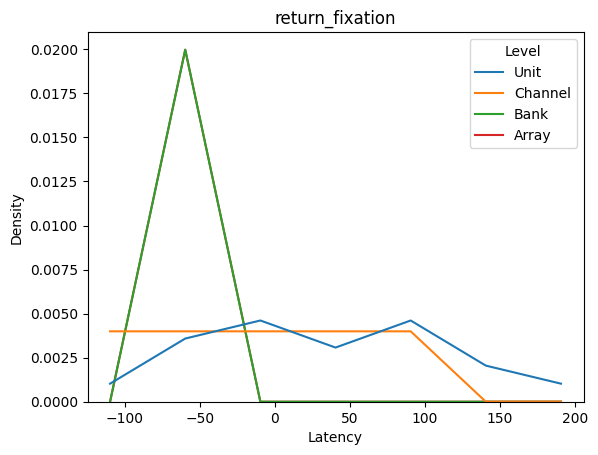

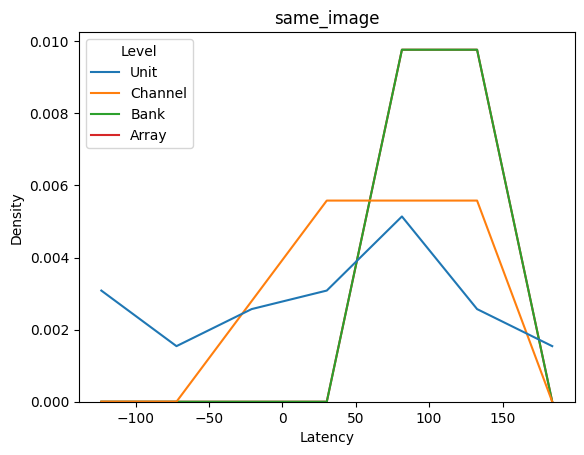

In [18]:
for cond, df in bycond_lat_df.items():
    plt.figure()
    sns.histplot(data=df[df['Clearance']>=clearance_thres], x='Latency', hue='Level', element='poly', fill=False, stat='density', common_norm=False)
    plt.title(cond)

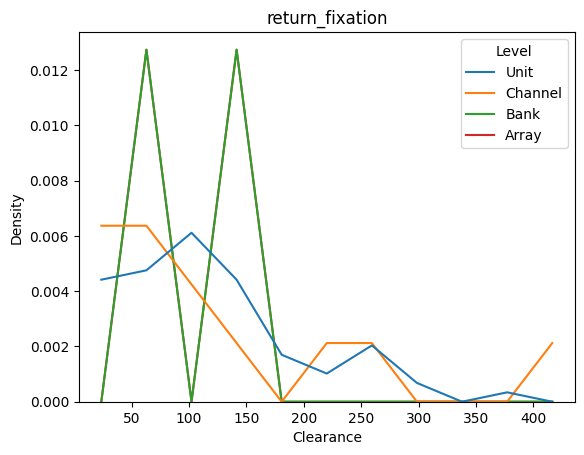

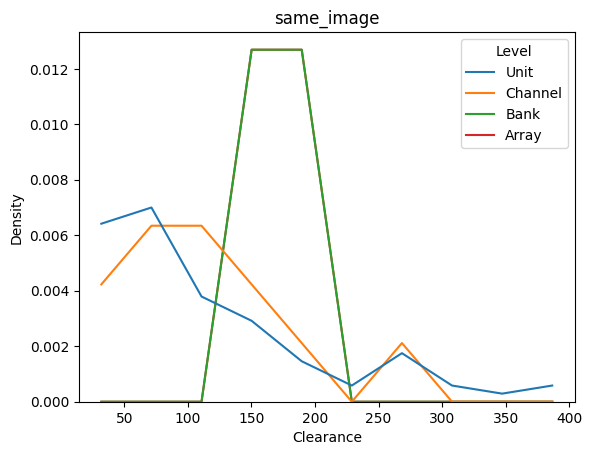

In [19]:
for cond, df in bycond_lat_df.items():
    plt.figure()
    sns.histplot(data=df, x='Clearance', hue='Level', element='poly', fill=False, stat='density', common_norm=False);
    plt.title(cond)

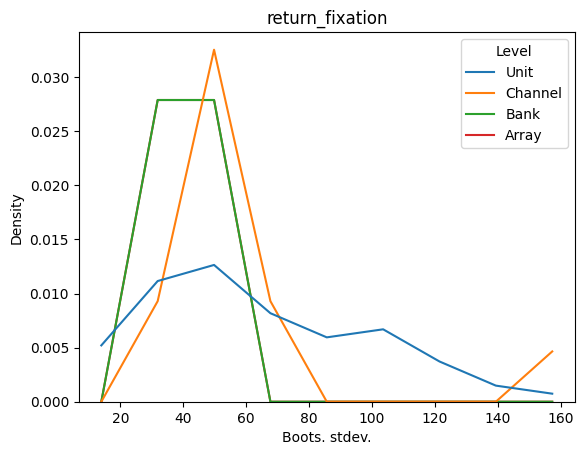

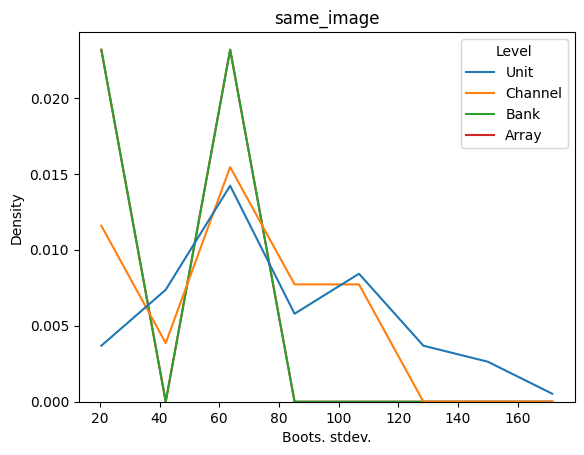

In [20]:
for cond, df in bycond_lat_df.items():
    plt.figure()
    sns.histplot(data=df, x='Boots. stdev.', hue='Level', element='poly', fill=False, stat='density', common_norm=False);
    plt.title(cond)